In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/552_crop6.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/267_crop16.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/50_crop12.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/405_crop11.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/598_crop9.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/435_crop2.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/435_crop14.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/373_crop8.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/175_crop13.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/107_crop6.png
/kaggle/input/major-final-kymograms-cropped/final kymograms croppe

In [ ]:
print "hello"

In [ ]:
from pathlib import Path
import shutil, os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

src_dir = Path("/kaggle/input/major-final-kymograms-cropped/final kymograms cropped")
dst_dir = Path("/kaggle/working/binary_split")

# Step 1: Map 3-class labels to binary
label_map = {
    'healthy': 'healthy',
    'functional': 'unhealthy',
    'organic': 'unhealthy'
}

# Step 2: Load and label all images
all_images = []
for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    if cls_dir.is_dir():
        mapped_label = label_map[cls]
        for img_path in cls_dir.glob("*.png"):
            all_images.append((img_path, mapped_label))

# Step 3: Split 15% test set
labels = [label for _, label in all_images]
trainval, test = train_test_split(all_images, test_size=0.15, stratify=labels, random_state=42)

# Step 4: Split 85% trainval into 70/15 split (82.35% train and 17.65% val of trainval)
trainval_labels = [label for _, label in trainval]
train, val = train_test_split(trainval, test_size=0.1765, stratify=trainval_labels, random_state=42)

# Step 5: Copy to new directory
def copy_images(data, split_name):
    for img_path, label in data:
        dest_dir = dst_dir / split_name / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, dest_dir / img_path.name)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f"✅ Data split complete:\n- Train: {len(train)}\n- Validation: {len(val)}\n- Test: {len(test)}")

# Step 6: Oversample to balance training set
train_dir = dst_dir / "train"
class_images = defaultdict(list)

for cls in os.listdir(train_dir):
    cls_path = train_dir / cls
    class_images[cls] = list(cls_path.glob("*.png"))

# Determine max class count
target_count = max(len(images) for images in class_images.values())

# Oversample
for cls, images in class_images.items():
    if len(images) < target_count:
        to_add = random.choices(images, k=target_count - len(images))
        for i, img_path in enumerate(to_add):
            new_name = img_path.stem + f"_dup{i}" + img_path.suffix
            shutil.copy(img_path, img_path.parent / new_name)

print(f"✅ Training set balanced using random oversampling (~{target_count} per class)")

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Define base path
base_path = Path("/kaggle/working/binary_split")

# Transform for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained ResNet-152
resnet = models.resnet152(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove classifier layer
resnet.eval()

# Function to extract features
def extract_features(data_path, save_prefix):
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc=f"Extracting from {save_prefix}"):
            output = resnet(inputs)
            features.append(output)
            labels.append(targets)

    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    np.save(f"/kaggle/working/{save_prefix}_features.npy", features)
    np.save(f"/kaggle/working/{save_prefix}_labels.npy", labels)

# Extract features for train, val, and test
extract_features(base_path / "train", "train")
extract_features(base_path / "val", "val")
extract_features(base_path / "test", "test")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 179MB/s]  
Extracting from test: 100%|██████████| 47/47 [04:40<00:00,  5.96s/it]


Epoch 1/30, Train Loss: 0.5965, Train Acc: 67.76%, Val Loss: 0.7697, Val Acc: 52.12%
Epoch 2/30, Train Loss: 0.5106, Train Acc: 73.79%, Val Loss: 0.4542, Val Acc: 76.84%
Epoch 3/30, Train Loss: 0.3877, Train Acc: 82.35%, Val Loss: 0.5918, Val Acc: 74.14%
Epoch 4/30, Train Loss: 0.3360, Train Acc: 85.41%, Val Loss: 0.4111, Val Acc: 80.61%
Epoch 5/30, Train Loss: 0.2621, Train Acc: 89.17%, Val Loss: 0.1937, Val Acc: 92.12%
Epoch 6/30, Train Loss: 0.1762, Train Acc: 93.15%, Val Loss: 0.1317, Val Acc: 95.49%
Epoch 7/30, Train Loss: 0.1395, Train Acc: 94.60%, Val Loss: 0.1033, Val Acc: 97.17%
Epoch 8/30, Train Loss: 0.1202, Train Acc: 95.51%, Val Loss: 0.1087, Val Acc: 95.82%
Epoch 9/30, Train Loss: 0.0937, Train Acc: 96.68%, Val Loss: 0.0780, Val Acc: 97.64%
Epoch 10/30, Train Loss: 0.0812, Train Acc: 96.86%, Val Loss: 0.0720, Val Acc: 97.51%
Epoch 11/30, Train Loss: 0.0684, Train Acc: 97.63%, Val Loss: 0.0679, Val Acc: 97.17%
Epoch 12/30, Train Loss: 0.0873, Train Acc: 96.54%, Val Loss: 0

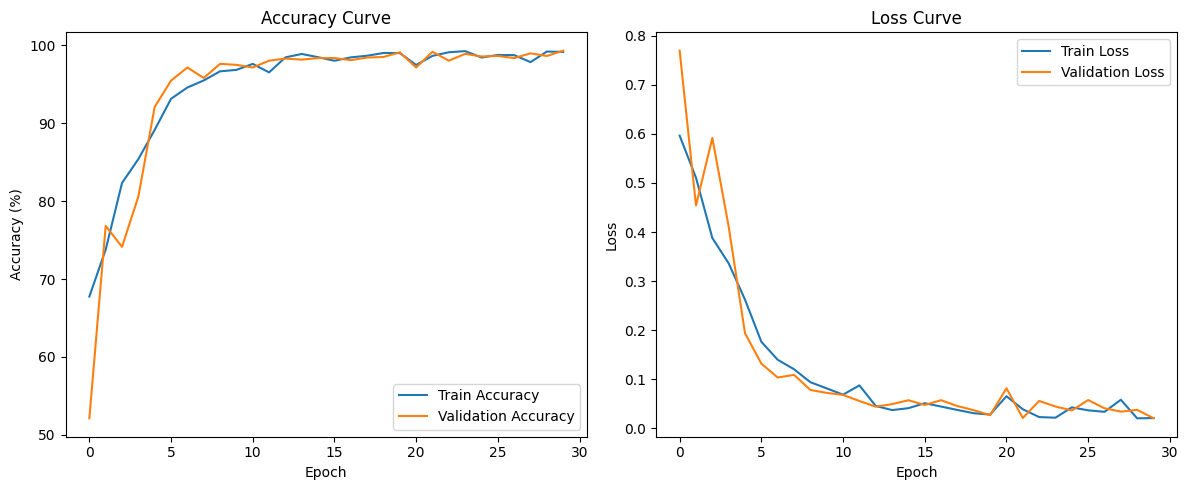

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Binary AlexNet-style Classifier
class AlexNetFeatureBinaryClassifier(nn.Module):
    def __init__(self, input_dim=2048):  # Corrected to init
        super(AlexNetFeatureBinaryClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2)  # Binary output
        )

    def forward(self, x):
        return self.classifier(x)

# Load features and labels
X_train = torch.tensor(np.load("/kaggle/working/train_features.npy"), dtype=torch.float32)
y_train = torch.tensor(np.load("/kaggle/working/train_labels.npy"), dtype=torch.long)

X_val = torch.tensor(np.load("/kaggle/working/val_features.npy"), dtype=torch.float32)
y_val = torch.tensor(np.load("/kaggle/working/val_labels.npy"), dtype=torch.long)

X_test = torch.tensor(np.load("/kaggle/working/test_features.npy"), dtype=torch.float32)
y_test = torch.tensor(np.load("/kaggle/working/test_labels.npy"), dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetFeatureBinaryClassifier(input_dim=2048).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# History for plotting
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Training
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = output.max(1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    train_acc = correct_train / total_train * 100
    history['train_loss'].append(total_loss / len(train_loader))
    history['train_acc'].append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_output = model(val_x)
            val_loss += criterion(val_output, val_y).item()
            _, predicted = val_output.max(1)
            correct_val += (predicted == val_y).sum().item()
            total_val += val_y.size(0)

    val_acc = correct_val / total_val * 100
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


Validation Performance of Binary AlexNet Classifier
Metrics             Value
----------------------------------------
Healthy
F1 Score (%)           99.46
Precision (%)          99.46
Recall (%)             99.46
Sensitivity (%)        99.46
Specificity (%)        99.09
----------------------------------------
Unhealthy
F1 Score (%)           99.09
Precision (%)          99.09
Recall (%)             99.09
Sensitivity (%)        99.09
Specificity (%)        99.46
----------------------------------------
Overall Accuracy (%)   99.33
AUC Score (%)          99.96


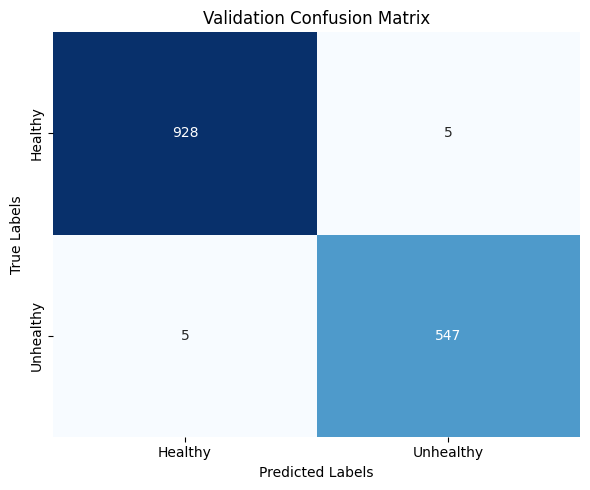

In [23]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# Set the model to evaluation mode
model.eval()

val_y_true = []
val_y_pred = []
val_y_probs = []

# Predict on validation data
with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)
        outputs = model(val_x)
        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        val_y_true.extend(val_y.cpu().numpy())
        val_y_pred.extend(preds.cpu().numpy())
        val_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
val_y_true = np.array(val_y_true)
val_y_pred = np.array(val_y_pred)
val_y_probs = np.array(val_y_probs)

# Class names
class_names = ['Healthy', 'Unhealthy']
n_classes = len(class_names)

# AUC Score (only for positive class probability)
val_auc = roc_auc_score(val_y_true, val_y_probs[:, 1]) * 100

# Classification report
val_report = classification_report(val_y_true, val_y_pred, target_names=class_names, output_dict=True)

# Confusion matrix
val_conf_matrix = confusion_matrix(val_y_true, val_y_pred)

# Sensitivity and Specificity
val_sensitivity = []
val_specificity = []

for i in range(n_classes):
    TP = val_conf_matrix[i, i]
    FN = val_conf_matrix[i].sum() - TP
    FP = val_conf_matrix[:, i].sum() - TP
    TN = val_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    val_sensitivity.append(sensitivity)
    val_specificity.append(specificity)

# Accuracy
val_acc = accuracy_score(val_y_true, val_y_pred) * 100

# Print Validation Report
print("\nValidation Performance of Binary AlexNet Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    
    print(f"{'F1 Score (%)':<20}{val_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{val_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{val_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{val_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{val_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{val_acc:>8.2f}")
print(f"{'AUC Score (%)':<20}{val_auc:>8.2f}")


plt.figure(figsize=(6, 5))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



Testing Performance of Binary AlexNet Classifier
Metrics             Value
----------------------------------------
Healthy
F1 Score (%)           99.46
Precision (%)          99.78
Recall (%)             99.14
Sensitivity (%)        99.14
Specificity (%)        99.64
----------------------------------------
Unhealthy
F1 Score (%)           99.10
Precision (%)          98.57
Recall (%)             99.64
Sensitivity (%)        99.64
Specificity (%)        99.14
----------------------------------------
Overall Accuracy (%)   99.33
Overall AUC Score (%)   99.97


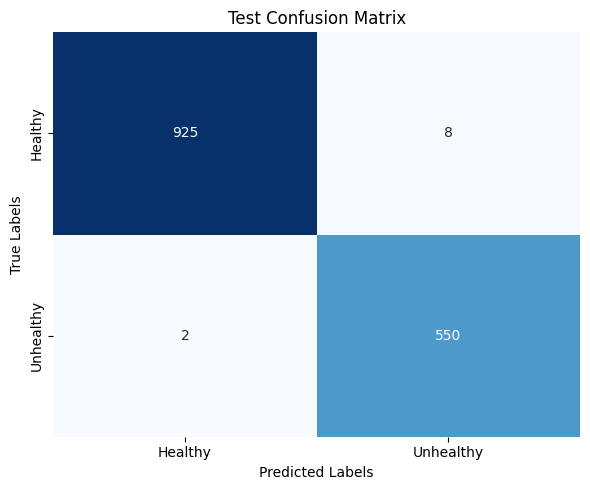

In [24]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()

test_y_true = []
test_y_pred = []
test_y_probs = []

# Predict on test data
with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        outputs = model(test_x)
        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        test_y_true.extend(test_y.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())
        test_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred)
test_y_probs = np.array(test_y_probs)

# Class names
class_names = ['Healthy', 'Unhealthy']
n_classes = len(class_names)

# Overall AUC Score (only for positive class probability)
test_auc = roc_auc_score(test_y_true, test_y_probs[:, 1]) * 100

# Classification report
test_report = classification_report(test_y_true, test_y_pred, target_names=class_names, output_dict=True)

# Confusion matrix
test_conf_matrix = confusion_matrix(test_y_true, test_y_pred)

# Sensitivity and Specificity
test_sensitivity = []
test_specificity = []

for i in range(n_classes):
    TP = test_conf_matrix[i, i]
    FN = test_conf_matrix[i].sum() - TP
    FP = test_conf_matrix[:, i].sum() - TP
    TN = test_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    test_sensitivity.append(sensitivity)
    test_specificity.append(specificity)

# Accuracy
test_acc = accuracy_score(test_y_true, test_y_pred) * 100

# Print Testing Report
print("\nTesting Performance of Binary AlexNet Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{test_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{test_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{test_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{test_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{test_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{test_acc:>8.2f}")
print(f"{'Overall AUC Score (%)':<20}{test_auc:>8.2f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import roc_auc_score

# If val_y_true is a tensor, convert to numpy and flatten
val_y_true_np = val_y_true.cpu().numpy().flatten() if torch.is_tensor(val_y_true) else val_y_true.flatten()

# val_y_probs[:, 1] gives probability of class 1 (positive class)
val_auc = roc_auc_score(val_y_true_np, val_y_probs[:, 1]) * 100

print(f"Validation AUC Score (%): {val_auc:.2f}")


Validation AUC Score (%): 99.96


In [1]:

torch.save(model.state_dict(), 'alexnet_model.pth')


NameError: name 'torch' is not defined